<a href="https://colab.research.google.com/github/acollin19/comp551/blob/main/A3/assignment3_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.datasets import fashion_mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow 
import keras
from sklearn.model_selection import train_test_split
import os
import shutil
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm


## Task 1: Process Data


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Train: X=(60000, 784), y=(60000,)
Test: X=(10000, 784), y=(10000,)


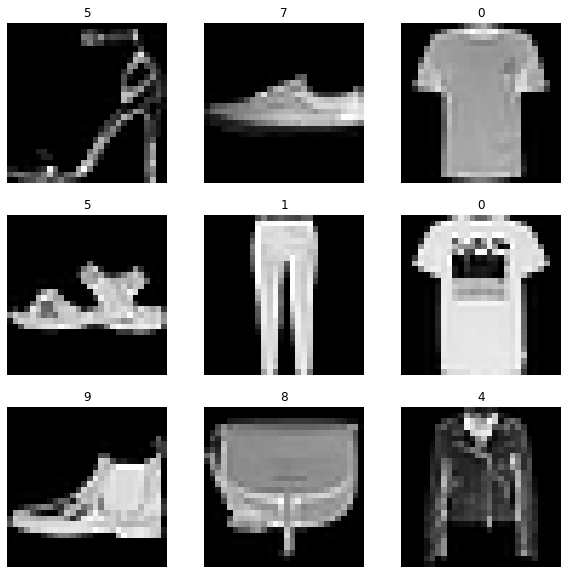

In [2]:
# load dataset
(X_train, y_train_val), (X_test, y_test_val) = fashion_mnist.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, y_train_val.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test_val.shape))

# Visualizing the MNIST images
sample_img_idx = np.random.randint(0, X_train.shape[0]+1, 9)
plt.figure(figsize=(10,10))
for i, j in enumerate(sample_img_idx):
    image, label = X_train[j], y_train_val[j]
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')

# Reshape and normalize the dataset
X_train = X_train.reshape(X_train.shape[0], 784)
X_train = X_train - np.mean(X_train, axis=0)
X_train = X_train / np.std(X_train, axis=0)

X_test = X_test.reshape(X_test.shape[0], 784)
X_test = X_test - np.mean(X_test, axis=0)
X_test = X_test / np.std(X_test, axis=0)

y_train = np_utils.to_categorical(y_train_val, 10) #10 classes
y_train = y_train == 1

y_test = np_utils.to_categorical(y_test_val, 10)
y_test = y_test == 1
print('Train: X=%s, y=%s' % (X_train.shape, y_train_val.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test_val.shape))

## Task 2: Multilayered Perceptron (MLP) Class

In [3]:
from typing import List

class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size) / 10
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        # print(gradient.shape, self.w.shape)
        return gradient.dot(self.w)

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient
        
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
            # print(layer.__class__.__name__, target.shape)

### Optimizer Classes

In [4]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, l2_reg=0):
        super().__init__(net)
        self.lr = lr
        self.l2_reg = l2_reg

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
          if (len(p.shape) > 1):
              p -= self.lr * (g.mean(axis=0) + self.l2_reg * p)       # regularize weights
          else:
            p -= self.lr * g.mean(axis=0)                             # but not biases

### MLP Class

In [5]:
class MLPClass():
  def __init__(self, steps, batch_size):
      self.steps = steps
      self.batch_size = batch_size

  def fit(self, mlp: MLP, optimizer: Optimizer, data_x, data_y, steps, batch_size, title, l2_reg=0):
      losses = []
      for _ in tqdm(range(self.steps)):
          indices = np.random.choice(data_x.shape[0], self.batch_size)
          batch_x = data_x[indices]
          batch_y = data_y[indices]
          predictions = mlp.forward(batch_x)

          norm = 0
          for layer in mlp.layers:
           if isinstance(layer, LinearLayer): norm += np.linalg.norm(layer.w)

          loss = -(batch_y * np.log(predictions)).sum(axis=-1).mean() + (l2_reg * norm / batch_size)
          losses.append(loss)
          mlp.backward(batch_y)
          optimizer.step()
      plt.plot(losses)
      plt.title(title)
      plt.xlabel("Epoch")
      plt.ylabel("Cross entropy loss")

  def predict(self, model, x):
      yh = model.forward(x)
      return  yh   

  def evaluate_acc(self, y_train_prob, y_test_prob, X_train, y_train_val, X_test, y_test_val):
      train_acc = np.sum(np.argmax(y_train_prob, axis=1) == y_train_val) / X_train.shape[0]
      test_acc = np.sum(np.argmax(y_test_prob, axis=1) == y_test_val) / X_test.shape[0] #instead of X_test

      return train_acc, test_acc




## Task 3: Experiments 

## Task 3.1.1 MLP with no hidden layers

100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


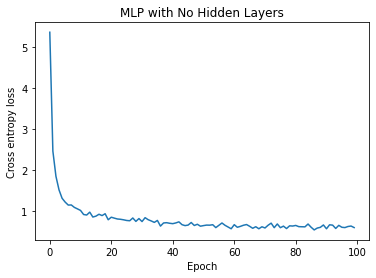

In [6]:
n_features = X_train.shape[-1]
GRADIENT_STEPS = 100
batch_size = 1000
model = MLPClass(GRADIENT_STEPS, batch_size)

mlp0 = MLP(
    LinearLayer(n_features, 10),
    SoftmaxOutputLayer()
)
opt0 = GradientDescentOptimizer(mlp0, 1e-1)
title = "MLP with No Hidden Layers"
model.fit(mlp0, opt0, X_train, y_train, GRADIENT_STEPS, batch_size, title) 


## Task 3.1.2 MLP with one hidden layer

100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


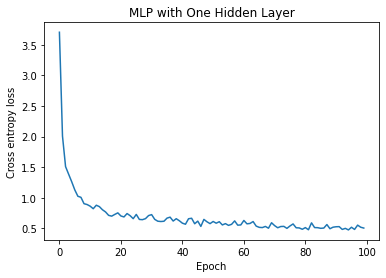

In [7]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128

mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, 1e-1)
title = "MLP with One Hidden Layer"
model.fit(mlp1, opt1, X_train, y_train, GRADIENT_STEPS, 1000, title)


## Task 3.1.3 MLP with two hidden layers


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


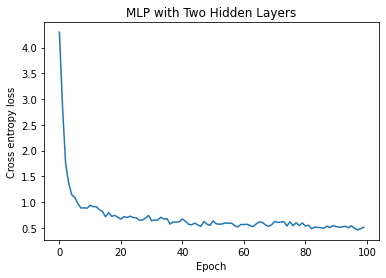

In [8]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, 1e-1)
title = "MLP with Two Hidden Layers"
model.fit(mlp2, opt2, X_train, y_train, 100, 1000, title)

### MLP Model Accuracies

In [9]:

# Model 1 Accuracy
y_train_prob = model.predict(mlp0, X_train)
y_test_prob = model.predict(mlp0, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with no hidden layer --> Training : {train_acc} ; Testing : {test_acc}.')

# Model 2 Accuracy
y_train_prob = model.predict(mlp1, X_train)
y_test_prob = model.predict(mlp1, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with one hidden layer --> Training Accuracy: {train_acc} ; Testing Accuracy: {test_acc}.')

# Model 3 Accuracy
y_train_prob = model.predict(mlp2, X_train)
y_test_prob = model.predict(mlp2, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with two hidden layers --> Training Accuracy: {train_acc} ; Testing Accuracy: {test_acc}.')



Accuracy of MLP with no hidden layer --> Training : 0.8060666666666667 ; Testing : 0.7914.
Accuracy of MLP with one hidden layer --> Training Accuracy: 0.8235666666666667 ; Testing Accuracy: 0.8135.
Accuracy of MLP with two hidden layers --> Training Accuracy: 0.8163166666666667 ; Testing Accuracy: 0.8005.


## Task 3.2 Different Activation Functions


In [10]:
# TanH
class TanHLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        t = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        self.gradient = 1-t**2
        return self.gradient

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

# Leaky-ReLU
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        negslope = 1e-2
        neg = negslope*np.minimum(0, x)
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x) + neg

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


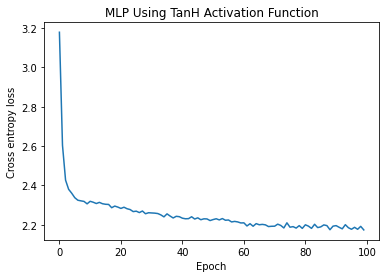

In [11]:
# TanH with 2 hidden layer MLP
tanHmlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
tanHopt2 = GradientDescentOptimizer(tanHmlp2, 1e-1)
title = "MLP Using TanH Activation Function"
model.fit(tanHmlp2, tanHopt2, X_train, y_train, 100, 10000, title)

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


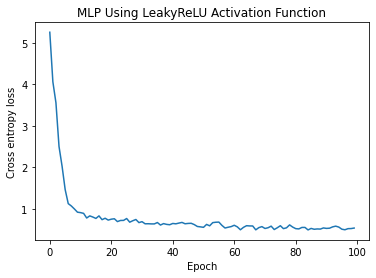

In [12]:
# LeakyReLU with 2 hidden layer MLP
leakyMlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
leakyOpt2 = GradientDescentOptimizer(leakyMlp2, 1e-1)
title = "MLP Using LeakyReLU Activation Function"

model.fit(leakyMlp2, leakyOpt2, X_train, y_train, 100, 1000, title)

In [13]:
# TanH Accuracy
y_train_prob = model.predict(tanHmlp2, X_train)
y_test_prob = model.predict(tanHmlp2, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with with TanH activation --> Training : {train_acc} ; Testing : {test_acc}.')


# Leaky ReLU Accuracy
y_train_prob = model.predict(leakyMlp2, X_train)
y_test_prob = model.predict(leakyMlp2, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with with Leaky Relu activation --> Training : {train_acc} ; Testing : {test_acc}.')


Accuracy of MLP with with TanH activation --> Training : 0.25638333333333335 ; Testing : 0.2516.
Accuracy of MLP with with Leaky Relu activation --> Training : 0.8125666666666667 ; Testing : 0.8007.


## Task 3.3 : L2 regularization on two Hidden Layer MLP

100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


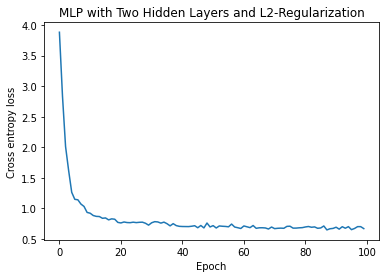

In [14]:
mlpReg = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
optReg = GradientDescentOptimizer(mlpReg, 1e-1, 0.1)
title = "MLP with Two Hidden Layers and L2-Regularization"
model.fit(mlpReg, optReg, X_train, y_train, 100, 1000, title, l2_reg=0.1)

In [15]:
y_train_prob = model.predict(mlpReg, X_train)
y_test_prob = model.predict(mlpReg, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with two hidden layers with regularization --> Training Accuracy: {train_acc} ; Testing Accuracy: {test_acc}.')

Accuracy of MLP with two hidden layers with regularization --> Training Accuracy: 0.7788666666666667 ; Testing Accuracy: 0.7724.


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


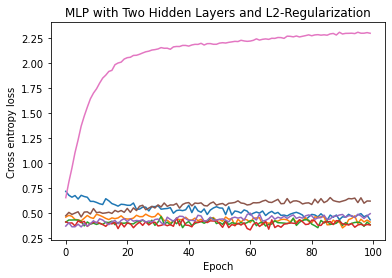

In [16]:
train = []
test = []

regs = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 1]
for reg in regs:
    optReg = GradientDescentOptimizer(mlpReg, 1e-1, reg)
    model.fit(mlpReg, optReg, X_train, y_train, 100, 1000, title, reg)
    y_train_prob = model.predict(mlpReg, X_train)
    y_test_prob = model.predict(mlpReg, X_test)
    train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
    train.append(train_acc)
    test.append(test_acc)

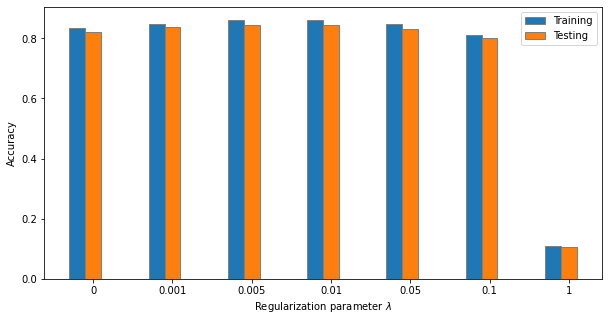

In [17]:
barWidth = 0.2
fig = plt.subplots(figsize=(10, 5))
br1 = np.arange(7)
br2 = [x + barWidth for x in br1]
plt.bar(br1, train, width=barWidth, edgecolor ='grey', label ='Training')
plt.bar(br2, test, width=barWidth, edgecolor ='grey', label ='Testing')
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth for r in range(7)], regs)
plt.legend(loc='best')
plt.show()

## Task 3.4 : Two Hidden Layer MLP Trained with Unnormalized Images

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-5-d6ac2222e634>:18: RuntimeWarning: divide by zero encountered in log
  loss = -(batch_y * np.log(predictions)).sum(axis=-1).mean() + (l2_reg * norm / batch_size)
<ipython-input-5-d6ac2222e634>:18: RuntimeWarning: invalid value encountered in multiply
  loss = -(batch_y * np.log(predictions)).sum(axis=-1).mean() + (l2_reg * norm / batch_size)
100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


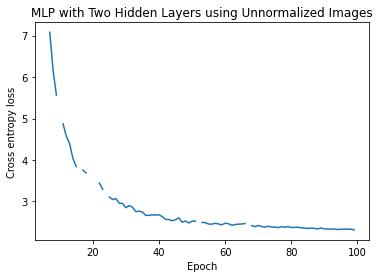

In [18]:
HIDDEN_SIZE = 128

# load dataset
(unnormalized_X_train, unnormalized_y_train), (unnormalized_X_test, unnormalized_y_test) = fashion_mnist.load_data()

unnormalized_X_train = unnormalized_X_train.reshape(unnormalized_X_train.shape[0], 784)
unnormalized_X_test = unnormalized_X_test.reshape(unnormalized_X_test.shape[0], 784)

unnormalized_y_train = np_utils.to_categorical(unnormalized_y_train)
unnormalized_y_test = np_utils.to_categorical(unnormalized_y_test)

title = "MLP with Two Hidden Layers using Unnormalized Images"
model.fit(mlp2, opt2, unnormalized_X_train, unnormalized_y_train, 100, 1000, title)

In [19]:
# No Normalization Accuracy
y_train_prob = model.predict(mlp2, unnormalized_X_train)
y_test_prob = model.predict(mlp2, unnormalized_X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  unnormalized_X_train, y_train_val, unnormalized_X_test, y_test_val)
print(f'Accuracy of MLP with no normalization on data --> Training : {train_acc} ; Testing : {test_acc}.')


Accuracy of MLP with no normalization on data --> Training : 0.09996666666666666 ; Testing : 0.1.


## Task 3.5 : Convolutional Neural Network (ConvNet)

In [20]:
# Reshape the images.
CNN_X_train = X_train.reshape(X_train.shape[0], 28,28,1)
CNN_X_test = X_test.reshape(X_test.shape[0], 28,28,1)


print(CNN_X_train.shape) # (60000, 28, 28) #train_images
print(CNN_X_test.shape)  # (60000, 28, 28) #train_labels
print(y_train.shape) # (60000,) # train_images
print(y_test.shape) # (60000,) # train_labels


(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [21]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 300
input_shape = (CNN_X_train.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input

model = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten (Flatten)           (None, 2304)              0

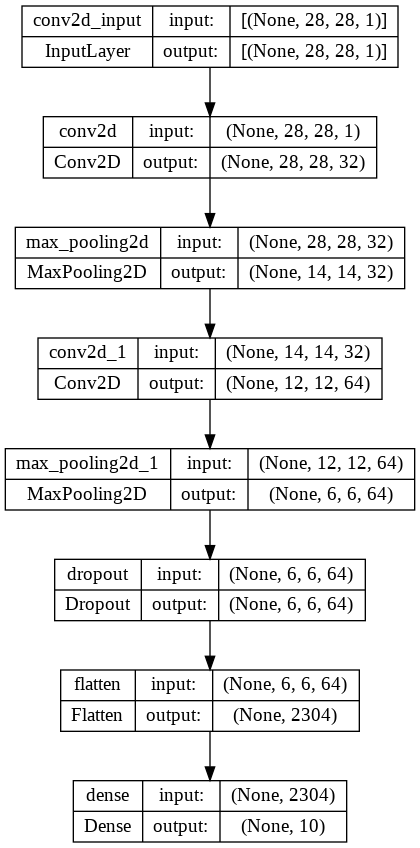

In [22]:
# Summary of the model 
model.summary()
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [23]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [24]:
# Train the mdoel
epochs = 20 # switch to GPU to run
# Saving the model during training to be used later
checkpoint = ModelCheckpoint("fashion_mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [25]:
# Fitting the model
history = model.fit(
  CNN_X_train,
  y_train, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(CNN_X_test, y_test), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.7881
Epoch 1: val_loss improved from inf to 0.40349, saving model to fashion_mnist_best_model.hdf5
200/200 [==============================] - 10s 10ms/step - loss: 0.6048 - accuracy: 0.7881 - val_loss: 0.4035 - val_accuracy: 0.8585
Epoch 2/20
197/200 [============================>.] - ETA: 0s - loss: 0.3743 - accuracy: 0.8689
Epoch 2: val_loss improved from 0.40349 to 0.34953, saving model to fashion_mnist_best_model.hdf5
200/200 [==============================] - 2s 8ms/step - loss: 0.3742 - accuracy: 0.8687 - val_loss: 0.3495 - val_accuracy: 0.8752
Epoch 3/20
199/200 [============================>.] - ETA: 0s - loss: 0.3317 - accuracy: 0.8831
Epoch 3: val_loss improved from 0.34953 to 0.32679, saving model to fashion_mnist_best_model.hdf5
200/200 [==============================] - 2s 8ms/step - loss: 0.3320 - accuracy: 0.8831 - val_loss: 0.3268 - val_accuracy: 0.8796
Epoch 4/20
196/200 [=======

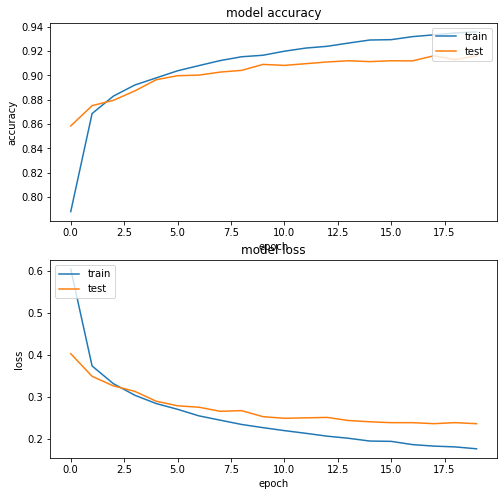

In [26]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 1s 2ms/step
Test error: 8.4%


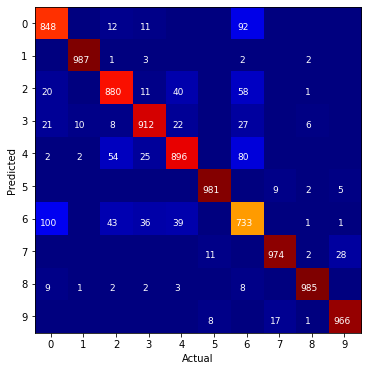

In [28]:
# Model predictions and confusion matrix
test_predictions = np.argmax(model.predict(CNN_X_test),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

## Task 3.6 : MLP Tuning

Reloading dataset for consistency purposes

In [29]:
# load dataset
(X_train, y_train_val), (X_test, y_test_val) = fashion_mnist.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, y_train_val.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test_val.shape))

# Reshape and normalize the dataset
X_train = X_train.reshape(X_train.shape[0], 784)
X_train = X_train - np.mean(X_train, axis=0)
X_train = X_train / np.std(X_train, axis=0)

X_test = X_test.reshape(X_test.shape[0], 784)
X_test = X_test - np.mean(X_test, axis=0)
X_test = X_test / np.std(X_test, axis=0)

y_train = np_utils.to_categorical(y_train_val, 10) #10 classes
y_train = y_train == 1

y_test = np_utils.to_categorical(y_test_val, 10)
y_test = y_test == 1
print('Train: X=%s, y=%s' % (X_train.shape, y_train_val.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test_val.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Train: X=(60000, 784), y=(60000,)
Test: X=(10000, 784), y=(10000,)


### Attempt 1: Adding more layers

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


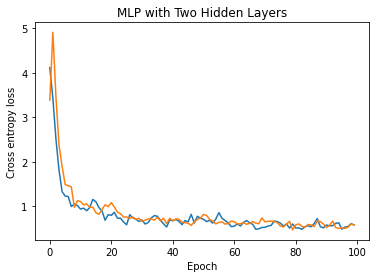

In [30]:
model = MLPClass(GRADIENT_STEPS, batch_size)

# MLP with three hidden layers
mlp3 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt3 = GradientDescentOptimizer(mlp3, 1e-1)
title = "MLP with Two Hidden Layers"
model.fit(mlp3, opt3, X_train, y_train, 100, 1000, title)

# MLP with four hidden layers
mlp4 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt4 = GradientDescentOptimizer(mlp4, 1e-1)
title = "MLP with Two Hidden Layers"
model.fit(mlp4, opt4, X_train, y_train, 100, 1000, title)


In [31]:
# Three Layer MLP Accuracy
y_train_prob = model.predict(mlp3, X_train)
y_test_prob = model.predict(mlp3, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with three hidden layers --> Training : {train_acc} ; Testing : {test_acc}.')

# Four Layer MLP Accuracy
y_train_prob = model.predict(mlp4, X_train)
y_test_prob = model.predict(mlp4, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP with four hidden layers --> Training : {train_acc} ; Testing : {test_acc}.')

Accuracy of MLP with three hidden layers --> Training : 0.8018166666666666 ; Testing : 0.7918.
Accuracy of MLP with four hidden layers --> Training : 0.7890166666666667 ; Testing : 0.7831.


### Attempt 2: Different activation function

When we tested the TanhH and LeakyReLU activation on 2 hidden layer MLP earlier, LeakyReLU increased the accuracy of 2 hidden layer MLP. 

Additionaly, the top 2 accuracies so far when testing number of hidden layers have been acheived with 0 and 1 hidden layer MLP, we'll test the sigmoid and LeakyReLU activation functions on these two MLPs.

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


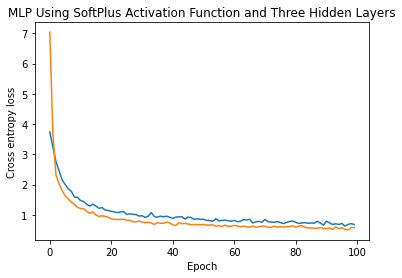

In [32]:
from numpy.ma.core import expand_dims
# SoftPlus
import math
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
GRADIENT_STEPS = 100
batch_size = 1000
model = MLPClass(GRADIENT_STEPS, batch_size)

class SoftPlusLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.log(1 + np.exp(-np.abs(x))) + np.maximum(x,0)
        return self.gradient

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient


# Sigmoid with 1 hidden layer MLP
softplusMlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    SoftPlusLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
softplusOpt1 = GradientDescentOptimizer(softplusMlp1, 1e-2)
title = "MLP Using SoftPlus Activation Function and One Hidden Layer"

model.fit(softplusMlp1, softplusOpt1, X_train, y_train, 100, 1000, title)


# Sigmoid with 2 hidden layer MLP
softplusMlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    SoftPlusLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    SoftPlusLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
softplusOpt2 = GradientDescentOptimizer(softplusMlp2, 1e-2)
title = "MLP Using SoftPlus Activation Function and Three Hidden Layers"

model.fit(softplusMlp2, softplusOpt2, X_train, y_train, 100, 1000, title)

In [33]:
# Leaky ReLU on one hidden layer Accuracy
y_train_prob = model.predict(softplusMlp1, X_train)
y_test_prob = model.predict(softplusMlp1, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP Using Softplus activation on one hidden layer --> Training : {train_acc} ; Testing : {test_acc}.')

# Leaky ReLU on three hidden layer Accuracy
y_train_prob = model.predict(softplusMlp2, X_train)
y_test_prob = model.predict(softplusMlp2, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP Using softplus activation on two hidden layer --> Training : {train_acc} ; Testing : {test_acc}.')




Accuracy of MLP Using Softplus activation on one hidden layer --> Training : 0.7543333333333333 ; Testing : 0.7434.
Accuracy of MLP Using softplus activation on two hidden layer --> Training : 0.80235 ; Testing : 0.7912.


In [ ]:
# LeakyReLU with 1 hidden layer MLP
leakyMlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
leakyOpt1 = GradientDescentOptimizer(leakyMlp1, 1e-2)
title = "MLP Using LeakyReLU Activation Function and One Hidden Layer"

model.fit(leakyMlp1, leakyOpt1, X_train, y_train, 100, 1000, title)


# LeakyReLU with three hidden layer MLP and bigger step size
leakyMlp3 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
leakyOpt3 = GradientDescentOptimizer(leakyMlp3, 1e-2)
title = "MLP Using LeakyReLU Activation Function and Three Hidden Layers"

model.fit(leakyMlp3, leakyOpt3, X_train, y_train, 200, 1000, title)

  1%|          | 1/100 [00:01<01:49,  1.11s/it]

In [ ]:
# Leaky ReLU on one hidden layer Accuracy
y_train_prob = model.predict(leakyMlp1, X_train)
y_test_prob = model.predict(leakyMlp1, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP Using Leaky ReLU on one Hidden Layer --> Training : {train_acc} ; Testing : {test_acc}.')

# Leaky ReLU on two hidden layer Accuracy
y_train_prob = model.predict(leakyMlp3, X_train)
y_test_prob = model.predict(leakyMlp3, X_test)
train_acc, test_acc = model.evaluate_acc(y_train_prob, y_test_prob,  X_train, y_train_val, X_test, y_test_val)
print(f'Accuracy of MLP Using Leaky ReLU on three Hidden Layer --> Training : {train_acc} ; Testing : {test_acc}.')


**Result:**  While Leaky ReLU on 1 and 2 hidden layer did not increasr the accuracy, we did obtain a slight increase in accuracy using the SoftPlus activation function on the 1 hidden layer MLP.